### Задача по прогнозированию ошибки модели оценки вероятности дефолта (MPP)
#### Описание задачи от банка Открытие:
Мы долго работали и построили модель оценки вероятности дефолта (PD модель). Все работает прекрасно, но нужно контролировать качество этой базовой модели и оценивать ошибку, индуцированную базовой моделью, поэтому нам нужно разработать модель прогнозирования ошибки (MPP). Ошибка в нашем случае - это разница между флагом flg_90_12_add, представляющим собой реализованное событие (0 - не дефолт, 1 - дефолт) и значением PD, представляющим собой оценку от нашей базовой модели.

Таким образом, Вам необходимо обучить модель прогнозирования ошибки с использованием двух датасетов и предсказать метрику |PD-flg_90_12_add| для тестовой выборки - тысячи последних экспериментов (incident), где значения PD и flg_90_12_add равны NaN.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import ensemble, model_selection, metrics 
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,cross_val_score
import xgboost as xgb
import sklearn
%matplotlib inline

In [2]:
data=pd.read_csv('data.csv',sep=',')
model=pd.read_csv('model.csv',sep=',')

In [3]:
print(data.shape)
data.head()

(82617, 1910)


,incident,flg_90_12_add,APPLICATION_MONTH,Category_Feature_0,Category_Feature_1,Category_Feature_2,Category_Feature_3,Category_Feature_4,Category_Feature_5,Category_Feature_6,...,Feature_1878,Feature_1879,Feature_1880,Feature_1881,Feature_1882,Feature_1883,Feature_1884,Feature_1885,Feature_1886,Feature_1887
0,14511110,0.0,2018-10,6.0,2,25,2.0,0.0,3,1,...,NaN,NaN,NaN,NaN,NaN,0,0,0,1,20184
1,15018800,0.0,2018-12,1.0,2,49,4.0,0.0,3,1,...,0.14384,0.259385,0.547065,0.28768,0.28768,0,1,1,1,20184
2,14499737,0.0,2018-10,6.0,2,24,1.0,0.0,3,0,...,NaN,0.420321,0.242687,NaN,NaN,0,1,0,1,20184
3,14953427,0.0,2018-12,4.0,2,26,1.0,0.0,3,1,...,NaN,NaN,NaN,NaN,NaN,0,1,1,1,20184
4,14744453,0.0,2018-11,6.0,2,30,4.0,2.0,3,1,...,NaN,0.045863,NaN,NaN,NaN,0,1,0,1,20184


Text(0, 0.5, 'Количество признаков')

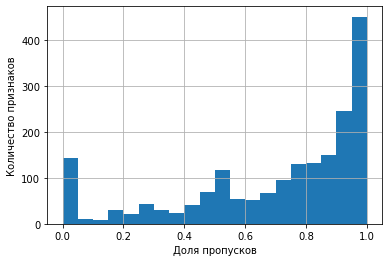

In [4]:
#missing data
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

#график для понимания масштабов пропусков
missing_data['Percent'].hist(bins=20)
plt.xlabel('Доля пропусков')
plt.ylabel('Количество признаков')

In [5]:
def data_preprocessing(data,max_percent_missed=70,threshold_for_metric=0.3):
   
    
    data=data.drop(list(missing_data[missing_data.Percent>(max_percent_missed*0.1)].index),axis=1)
    
    #обработка дат
    data.APPLICATION_MONTH = data.APPLICATION_MONTH.apply(pd.to_datetime)
    data['year'] = data.APPLICATION_MONTH.apply(lambda x : x.year)
    data['month'] = data.APPLICATION_MONTH.apply(lambda x : x.month)
    data=data.drop(['APPLICATION_MONTH'],axis=1)
    
    # присоединяем столбец PD с оценкой базовой модели по номеру инцидента
    Pd_flg_data=data.merge(model,on='incident',how='outer')
    
    # создаем признак metric с целевой переменной, как модуль разности PD и pd_flag_data
    Pd_flg_data['metric']=abs(Pd_flg_data['PD']-Pd_flg_data['flg_90_12_add'])
    
    
    #разбиение всего датасета на train и test по отсутсви. признака flg_90_12_add
    data_test=Pd_flg_data[Pd_flg_data.flg_90_12_add.isnull()]
    data_train=Pd_flg_data.drop(list(data.loc[data.flg_90_12_add.isnull()].index),axis='index')
    
    data_train=data_train.drop(['flg_90_12_add','incident','PD'],axis=1)
    data_test=data_test.drop(['flg_90_12_add','incident','PD'],axis=1)
    
    #удаляем строки, в которых metric принимает нетипично большие значения, чтобы не обучаться на выбросах
    data_train=data_train[data_train['metric']<=threshold_for_metric]
    
    #заполняем пропуски нулями
    data_train=data_train.fillna(0)
    data_test=data_test.fillna(0)
    
    # отделяем целевую переменную от всего датасета для трейна и теста
    train_labels=data_train['metric']
    data_train=data_train.drop(['metric'],axis=1)
    data_train=data_train.drop(['month','year'],axis=1)
    
    data_test=data_test.drop(['metric'],axis=1)
    data_test=data_test.drop(['month','year'],axis=1)
    

    return(data_train,data_test,train_labels)

In [6]:
%%time
data_train,data_test,train_labels=data_preprocessing(data,max_percent_missed=70,threshold_for_metric=0.3)

Wall time: 21.2 s


In [7]:
#масштабируем признаки
scaler = StandardScaler()
scaler.fit(data_train, train_labels)
data_train = scaler.transform(data_train)

data_test = scaler.transform(data_test)

In [8]:
xgb_regr=xgb.XGBRegressor(n_estimators=500,max_depth=3,verbosity=3,eval_metrics=metrics.mean_absolute_error)
xgb_regr.fit(data_train,train_labels)

[15:32:47] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/gbm/gbtree.cc:155: Using tree method: 2
[15:32:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:32:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:32:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:32:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:32:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:32:58] INFO: C:/Us

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metrics=<function mean_absolute_error at 0x0000022E7E44C940>,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=3)

In [10]:
predictions=pd.Series(abs(xgb_regr.predict(data_test)))
#predictions.to_csv('MPP_answer.csv',index=False)

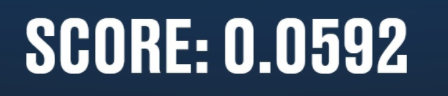

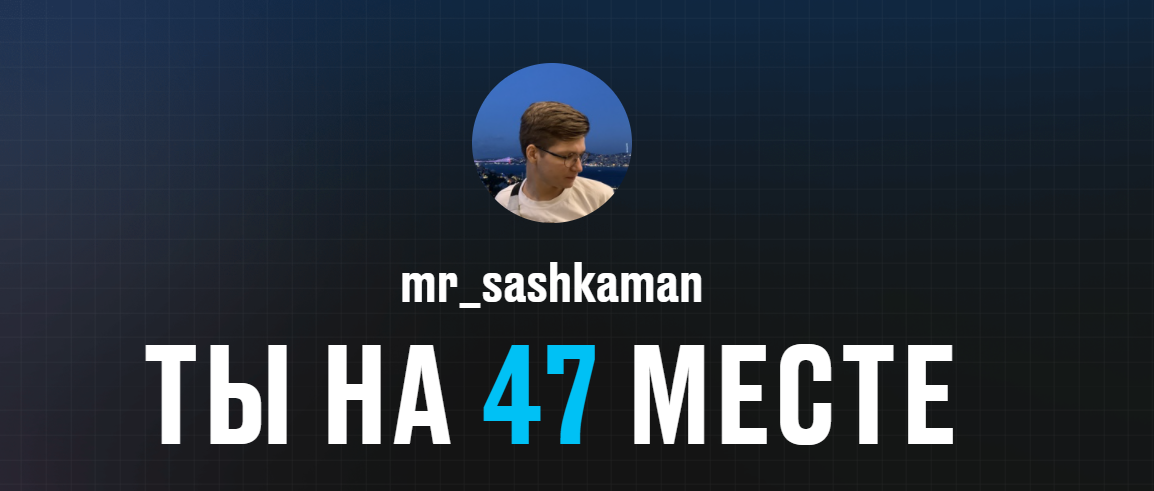